In [79]:
import tensorflow as tf
import numpy as np
import os

import math
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import schedules
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from models.resnet_ca_cnn import ResNet18
from utils.plotting_utils import plot_history
from utils.module_builders import get_classifier
from data import mechanic_components_loader
from causal_aggregation.causality_weigher import CausalityWeigher
from causal_aggregation.causality import CausalityMatrix

In [80]:
key = 123

np.random.seed(key)
tf.random.set_seed(key)

In [81]:
saves = os.path.join(os.getcwd(), "models_saved")

In [82]:
def get_save_path(model, name = None):
    if name is None:
        name = model.name
    
    return os.path.join(saves, name) + ".weights.h5"

def save_model(model, name = None):
    save_path = get_save_path(model, name)
    model.save_weights(save_path)
    
def load_model(model, name = None):
    save_path = get_save_path(model, name)
    model.load_weights(save_path)

In [83]:
batch_size = 16
mechanical_components_config = mechanic_components_loader.load(batch_size, key) # load dataset

In [84]:
input_shape = mechanical_components_config.input_shape
width, height, dim = input_shape

num_classes = mechanical_components_config.num_classes
num_features = 512
epochs = 15

In [85]:
train_ds, val_ds, test_ds = mechanical_components_config.datasets

steps_per_epoch = mechanical_components_config.steps_per_epoch
validation_steps = mechanical_components_config.validation_steps

In [86]:
lr_schedule = schedules.ExponentialDecay(
    1e-4,
    decay_steps=20,
    decay_rate=0.9,
    staircase=False
)

def build_optimizer():
    optimizer = tf.keras.optimizers.Adam(lr_schedule)
    return optimizer

In [87]:
METRICS = [
    "accuracy",
]

In [88]:
agg = "flatten"
classifier = "classic"

model_name = f"defect_resnet18_{agg}_{classifier}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(saves, model_name) + ".weights.h5", 
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)
callbacks = [checkpoint]

model_resnet_18 = ResNet18(num_classes, num_features, input_shape, aggregation=agg, classifier=classifier)
load_model(model_resnet_18, "defect_resnet18_flatten_classic")

optimizer = build_optimizer()

model_resnet_18.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=METRICS
)

In [89]:
numerator_denominator_pairs = {"max": ("max", "sum"), "min": ("min", "sum"), "lehmer": (0., 0.)}

In [90]:
pretrained_resnet = model_resnet_18.layers[1]
numerator, denominator = numerator_denominator_pairs["max"]

conv = Sequential([
    pretrained_resnet,
    layers.ReLU(max_value = 1),
])
    
ca = CausalityMatrix(
    numerator="max", 
    denominator="sum",
    calculates_grad=True,
)
causality_matrix = Sequential([
    layers.Permute((3, 1, 2)),
    ca
])

classifier = get_classifier("classic", num_classes, num_features)

inputs = layers.Input(shape=(width, height, dim))

features = pretrained_resnet(inputs)
features = layers.ReLU(max_value = 1)(features)
flat_features = layers.Flatten()(features)
matrix = layers.Permute((3, 1, 2))(features)
matrix = ca(matrix)

flat_matrix = layers.Flatten()(matrix[0])
features_concatenated = layers.Concatenate(axis = 1)([flat_features, flat_matrix])
outputs = classifier(features_concatenated)

model_resnet_18 = tf.keras.models.Model(inputs = inputs, outputs = outputs, name = "resnet18ca")


model_resnet_18.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_resnet_18_conv = tf.keras.models.Model(inputs = inputs, outputs = [features, outputs], name = "resnet18ca")

model_resnet_18_conv.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [91]:
pretrained_resnet = model_resnet_18.layers[1]
numerator, denominator = numerator_denominator_pairs["max"]

conv = Sequential([
    layers.InputLayer(input_shape=(width, height, dim)),
    pretrained_resnet,
    layers.ReLU(max_value = 1),
])

ca = CausalityMatrix(
    numerator='max', 
    denominator='sum',
    calculates_grad=True,
)
causality_matrix = Sequential([
    layers.Permute((3, 1, 2)),
    ca
])

inputs = layers.Input(shape=(width, height, dim))
features = conv(inputs)
flat_features = layers.Flatten()(features)
outputs = causality_matrix(features)[0]

model_plotter = tf.keras.models.Model(inputs = inputs, outputs = [features, outputs], name = "resnet18ca")
model_plotter.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [92]:
def saliency(model, image, desaturate=False, class_idx=None):
    with tf.GradientTape() as tape:
        tape.watch(image)
        _, loss = model(image)
        
        if class_idx is not None:
            loss = loss[:, class_idx]
        
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    if desaturate:
        gradient = gradient * image
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    # convert to numpy
    gradient = gradient.numpy()
    
    # normalize between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
    smap = smap.transpose([1, 2, 0])
    
    return smap

In [93]:
jet = plt.colormaps["jet"]
jet_colors = jet(np.arange(256))[:, :3]

def grad_cam(model, image, class_idx=None):
    with tf.GradientTape() as tape:
        tape.watch(image)
        features, causality = model(image)
        
        if class_idx is not None:
            causality = causality[:, class_idx]
        
    gradient = tape.gradient(causality, features)
    pooled_gradient = tf.reduce_mean(gradient, axis=(0, 1, 2))
    
    features = features[0]
    
    heatmap = features @ pooled_gradient[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = tf.where(tf.math.is_nan(heatmap), tf.zeros_like(heatmap), heatmap)
    
    heatmap = np.uint8(255 * heatmap)
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[2]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
    return jet_heatmap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

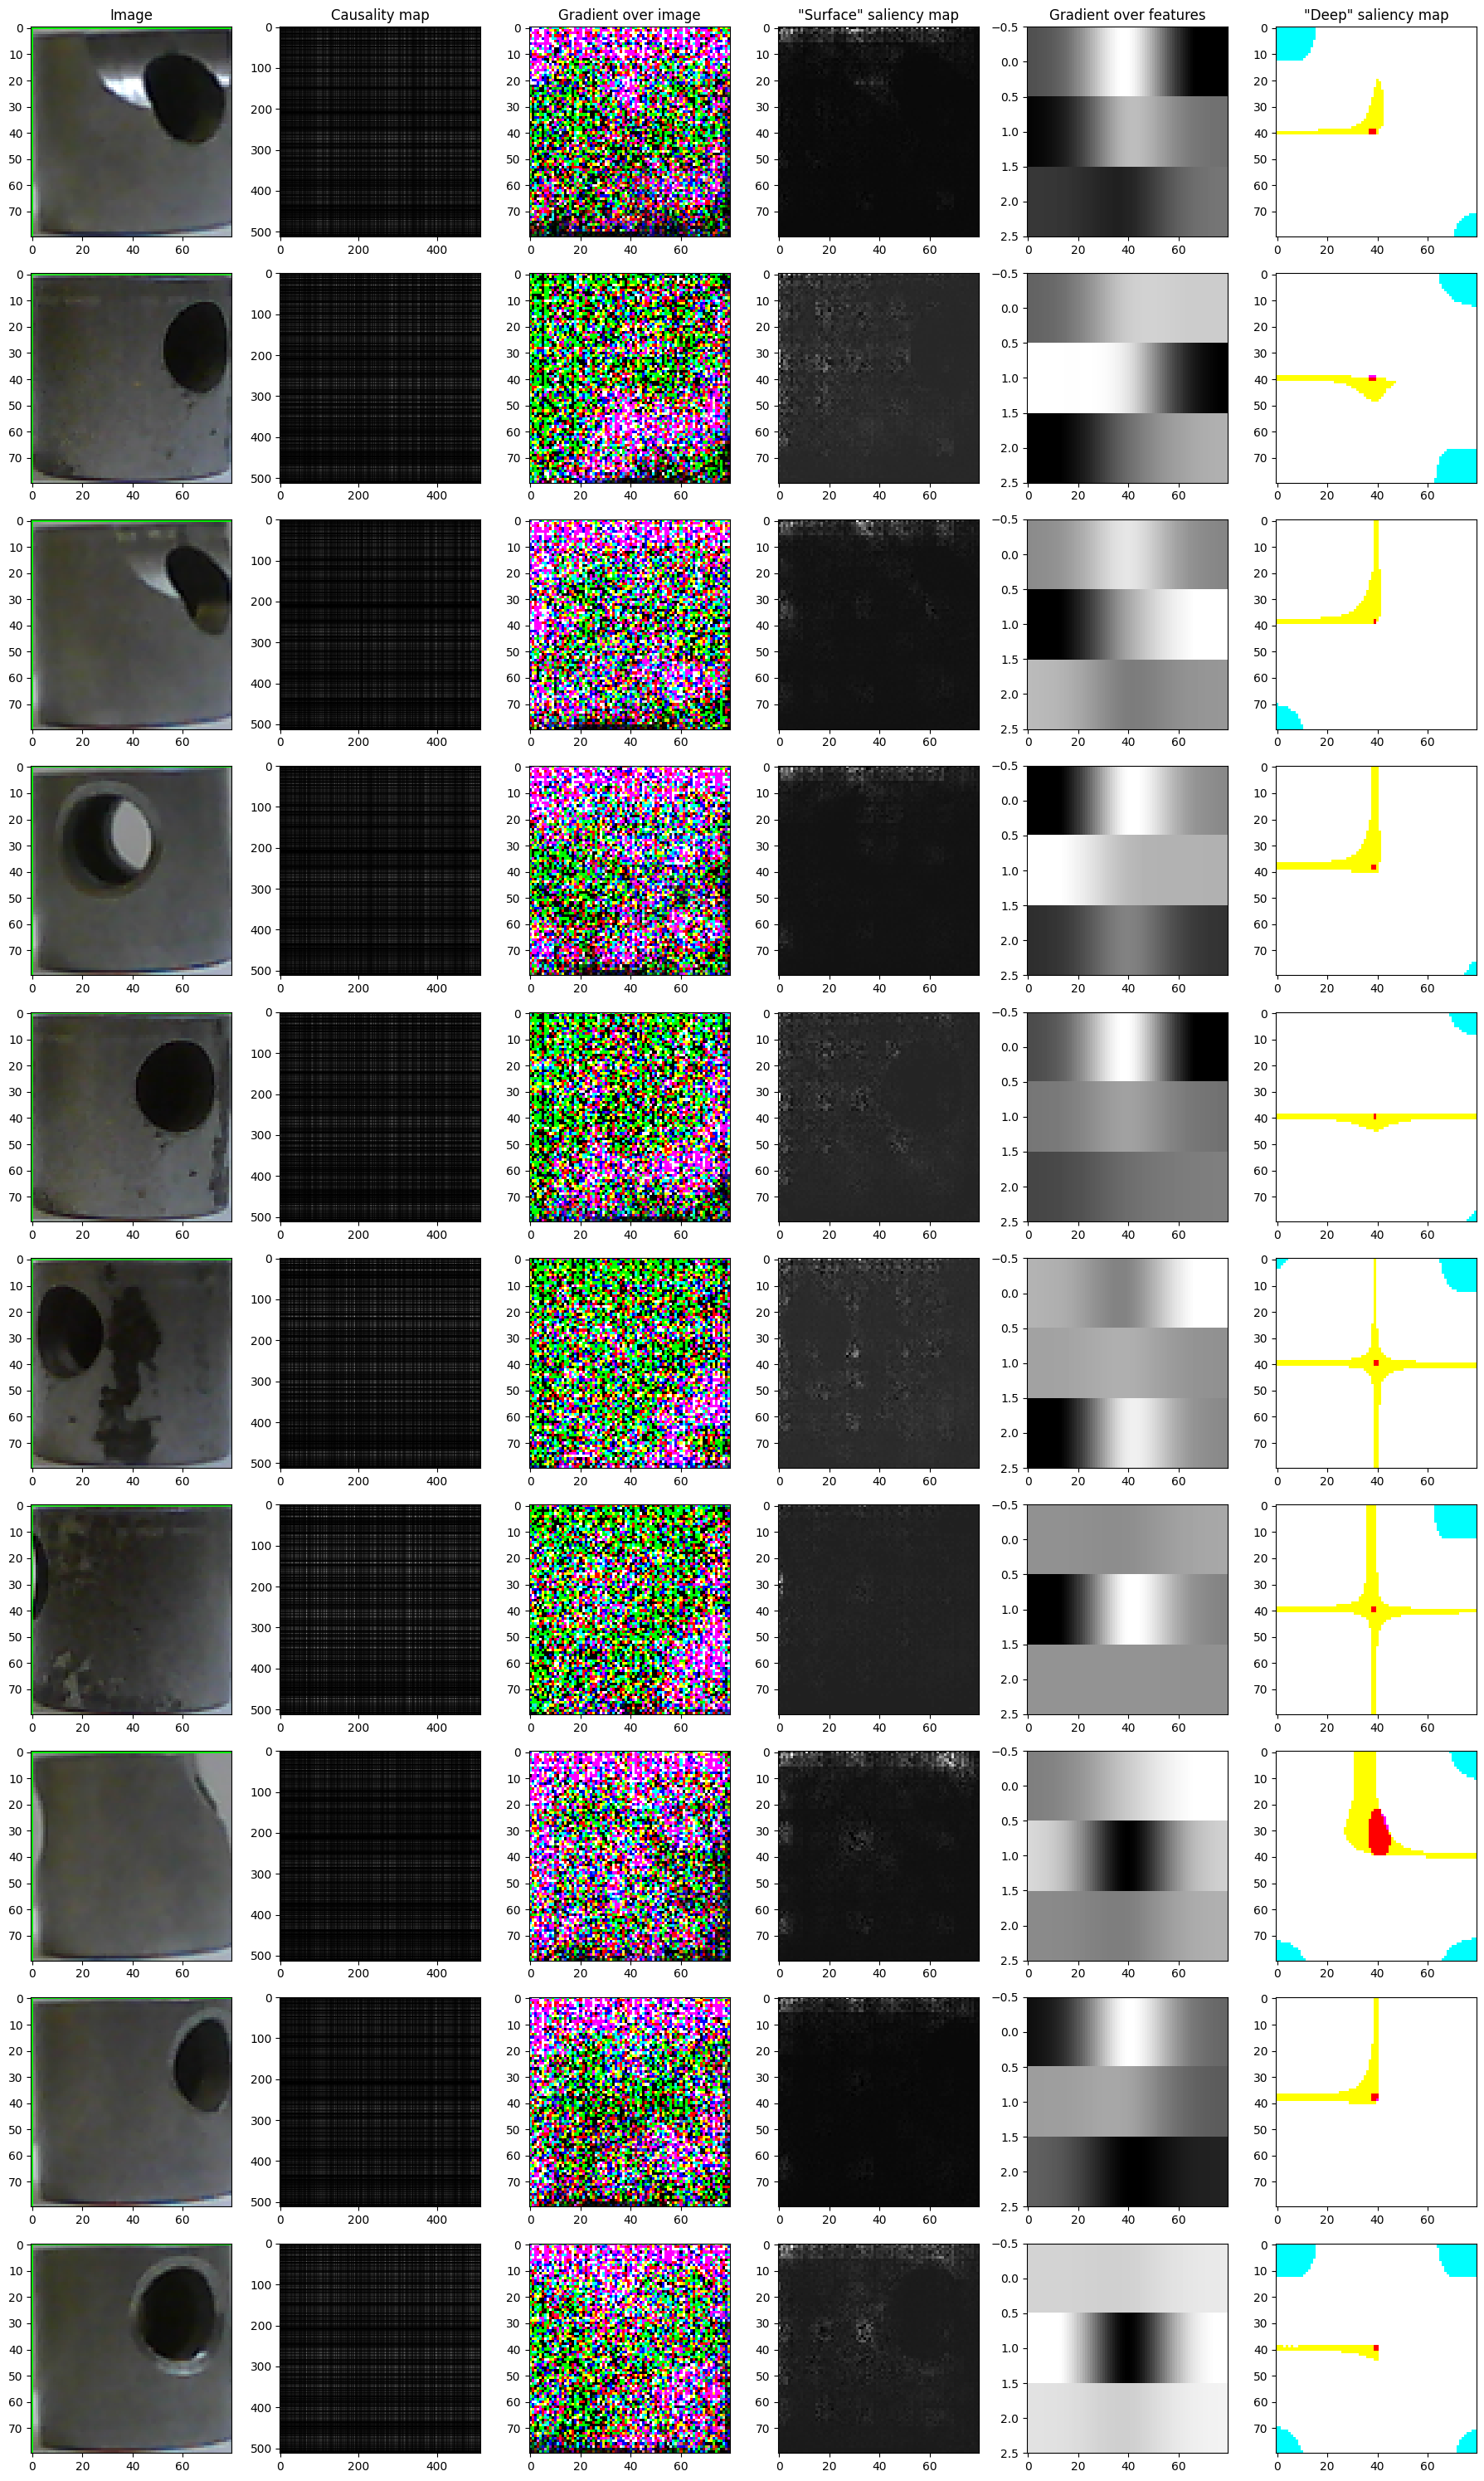

In [94]:
iterator = iter(test_ds)
samples = 10

cols = [
    'Image',
    'Causality map',
    'Gradient over image',
    '"Surface" saliency map',
    'Gradient over features',
    '"Deep" saliency map',
]
fig, axes = plt.subplots(nrows=samples, ncols=len(cols), figsize=(3 * len(cols), 3 * samples))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

weigher = CausalityWeigher()

samples_list = None
ids_list = None

for i in range(int(math.ceil(samples / batch_size))):
    samples_batch, ids_batch = next(iterator)
    
    samples_batch = samples_batch
    if samples_list is None:
        samples_list = samples_batch
    else:
        samples_list = tf.concat([samples_list, samples_batch], axis=0)
        
    ids_batch = ids_batch
    if ids_list is None:
        ids_list = ids_batch
    else:
        ids_list = tf.concat([ids_list, ids_batch], axis=0)

for i in range(samples):
    sample = samples_list[i]
    class_id = ids_list[i]
    
    image = sample 
    inputs = tf.expand_dims(sample, 0)
    
    class_idx = tf.math.argmax(tf.squeeze(model_resnet_18_conv(inputs)[1]))
    image_saliency = saliency(model_resnet_18_conv, inputs, class_idx=class_idx)
    image_saliency_desaturated = saliency(model_resnet_18_conv, inputs, desaturate=True, class_idx=class_idx)
    
    axes[i, 0].imshow(image, aspect='auto', cmap="gray")
    
    with tf.GradientTape() as tape:
        tape.watch(inputs) 
        features, causal_matrix = model_plotter(inputs)
    
    causal_matrix_reshaped = causal_matrix.numpy().reshape((num_features, num_features))  
    axes[i, 1].imshow(causal_matrix_reshaped, aspect='auto', cmap="gray")
    
    surface_causal_shadow = tape.gradient(causal_matrix, inputs)
    surface_causal_shadow = tf.squeeze(surface_causal_shadow)
    axes[i, 2].imshow(surface_causal_shadow, aspect='auto', cmap="gray")
    
    causal_saliency_desaturated = saliency(model_plotter, inputs, desaturate=True)
    axes[i, 3].imshow(causal_saliency_desaturated, aspect='auto', cmap="gray")
    
    with tf.GradientTape() as tape:
        tape.watch(inputs) 
        features, causal_matrix = model_plotter(inputs)

    deep_causal_shadow = tape.gradient(causal_matrix, features)
    deep_causal_shadow = tf.squeeze(deep_causal_shadow)
    deep_causal_shadow = tf.reduce_mean(deep_causal_shadow, axis=-1)
    deep_causal_shadow = tf.expand_dims(deep_causal_shadow, axis=-1)
    
    deep_causal_shadow = keras.utils.array_to_img(deep_causal_shadow)
    deep_causal_shadow = deep_causal_shadow.resize((image.shape[1], image.shape[2]))
    deep_causal_shadow = keras.utils.img_to_array(deep_causal_shadow)
    
    axes[i, 4].imshow(deep_causal_shadow, aspect='auto', cmap="gray")
    
    causal_cam = grad_cam(model_plotter, inputs)
    axes[i, 5].imshow(causal_cam, aspect='auto', cmap="gray")

plt.tight_layout()
plt.show()